In [ ]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite==0.9.7

In [ ]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

import math
import csv
import re
import pickle

Read datasets to help is in NER recognition

In [ ]:
# This is the character name dataset that is going to be used to enhance the prediction on the B-Character_Name and
# I-Character_Name classes

def read_and_clean_char_names(file_name):
  with open(file_name, 'r') as csvfile:
      names=[]
      x = csv.reader(csvfile)
      for row in x:
        if re.match("^Q\d",row[0]):
          continue
        else:
           if len(row[0].split())<=2:
            cleaned_row = row[0].lower().replace("mrs","").replace("mr","").replace(".","").strip()
            name=[]
            for cln_rw in cleaned_row.split():
              if len(cln_rw) > 2:
                name.append(cln_rw)
            names.append(name)
  return names

In [ ]:
file_name = "char_names.csv"
char_names = read_and_clean_char_names(file_name)

In [ ]:
print(char_names)

[['robert', 'muldoon'], ['nigel'], ['sam', 'weir'], ['vampira'], ['oto-hime'], ['puhek'], ['gwgon', 'gleddyfrudd'], ['orochimaru'], ['dukhat'], ['mags'], ['sito', 'jaxa'], ['clove'], ['thresh'], ['fat', 'lady'], ['father', 'wolf'], ['mantenna'], ['scar'], ['luppi', 'antenor'], ['chip', 'skylark'], ['galius', 'zed'], ['gwen', 'raiden'], ['anger'], ['jinjur'], ['kotone', 'noda'], ['lord', 'camembert'], ['mongo'], ['georges', 'querelle'], ['treeson'], ['familia'], ['atton', 'rand'], ['beckett'], ['ricardo'], ['riff', 'raff'], ['rocco', 'schiavone'], ['serena'], ['jean', 'marteau'], ['shapoklyak'], ['sambara'], ['biranha'], ['kiki', 'jerome'], ['harry', 'warner'], ['daohang', 'tianzun'], ['super', 'indian'], ['mongroid'], ['henry', 'huggins'], ['moon', 'man'], ['arle', 'nadja'], ['giovanni', 'rossi'], ['captain', 'tarpals'], ['bartje'], ['obould', 'many-arrows'], ['patof'], ['sandrine'], ['soundblaster'], ['taruia'], ['gosamyr'], ['amadeus', 'arkham'], ['argon'], ['the', 'doctor'], ['the',

In [ ]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [ ]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [ ]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [ ]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [ ]:
# This function checks if a given token is a first name or a last name or both or neither.
def is_char_name(token):
    is_first_name=False
    is_last_name=False
    for name in char_names:
      if len(name)>0 and token.lower() == name[0].lower():
        is_first_name=True
      if len(name)>1 and token.lower() == name[1].lower():
        is_last_name=True
      if (is_first_name and is_last_name):
        break
    return str(is_first_name)+"@"+str(is_last_name)

In [ ]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    ''' The pre-processing format is word@PosTag@is_first_name@is_last_name'''
    if(len(example[0]) ==2): # in the form (word,tag)
      # add the pos tag
      preprocessed_example = (list(map(lambda x:(x[0]+"@"+posttagger.tag([x[0]])[0][1],x[1]), example )))
      # add the is_char
      preprocessed_example = (list(map(lambda x:(x[0]+"@"+is_char_name(x[0].split("@")[0]),x[1]), preprocessed_example )))
    else: # in the form (word)
      preprocessed_example = (list(map(lambda x:(x+"@"+posttagger.tag([x[0]])[0][1]), example )))
      # add is_char
      preprocessed_example = (list(map(lambda x:(x+"@"+is_char_name(x[0].split("@")[0])), preprocessed_example )))
    return preprocessed_example

In [ ]:
# Testing the preProcess function
sent = [('Steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('an', 'O'), ('epic', 'B-Plot'), ('song', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
test_sent = preProcess(sent)
print(test_sent)

[('Steve@PRPVBP@True@True', 'B-Actor'), ('mcqueen@CD@True@True', 'I-Actor'), ('provided@VBN@False@False', 'O'), ('an@DT@False@False', 'O'), ('epic@JJ@False@False', 'B-Plot'), ('song@JJ@True@True', 'I-Plot'), ('chase@VB@True@True', 'I-Plot'), ('in@IN@False@False', 'I-Plot'), ('this@DT@False@False', 'I-Plot'), ('greatest@JJS@False@False', 'B-Opinion'), ('of@IN@False@False', 'I-Opinion'), ('all@DT@True@False', 'I-Opinion'), ('ww@VB@False@False', 'B-Plot'), ('2@CD@False@False', 'I-Plot'), ('prison@NN@True@False', 'I-Plot'), ('escape@NN@False@False', 'I-Plot'), ('movies@NNS@False@False', 'I-Plot')]


In [ ]:
# This cell is responsible for pre Processing the data. However, It is commented because it takes a very long time to run.
''' this step takes about 150 mins, I suggest
using the already provided preprocessed data (preProcessedData.pkl) by runing subsequent cells.
 if you still want to run this cell:
   simply un comment it and every thing should work normally
However, I suggest testing the logic with a simpler input (like the one included in the cell above) and
move on to use the pre Processed data I provided
 '''
# training_data =[]
# for example_idx in range(len(raw_training_data)):
#   training_data.append(preProcess(raw_training_data[example_idx]))
#   percentage_done = ((example_idx+1)/len(raw_training_data) )*100
#   percentage_done = round(percentage_done,2)
#   sys.stdout.write('\r'+"loading... " + str(percentage_done)+"%")

# # write preprocessed data to a file (in order to avoid long waiting times every time I run this code)
# pre_processed_data_location = "preProcessedData.pkl"
# with open(pre_processed_data_location, 'wb') as f:
#     pickle.dump(training_data, f)


' this step takes about 150 mins, I suggest\nusing the already provided preprocessed data (preProcessedData.pkl) by runing subsequent cells.\n if you still want to run this cell:\n   simply un comment it and every thing should work normally\nHowever, I suggest testing the logic with a simpler input (like the one included in the cell above) and\nmove on to use the pre Processed data I provided\n '

In [ ]:
# read preprocessed data from file
pre_processed_data_location = "preProcessedData.pkl"
with open(pre_processed_data_location, 'rb') as f:
  training_data=pickle.load(f)

In [ ]:
# check the effect of pre-processing
print(*training_data[0:10],sep="\n")

[('steve@PRPVBP@True@True', 'B-Actor'), ('mcqueen@CD@True@True', 'I-Actor'), ('provided@VBN@False@False', 'O'), ('a@DT@False@False', 'O'), ('thrilling@VBG@False@False', 'B-Plot'), ('motorcycle@NN@False@False', 'I-Plot'), ('chase@VB@True@True', 'I-Plot'), ('in@IN@False@False', 'I-Plot'), ('this@DT@False@False', 'I-Plot'), ('greatest@JJS@False@False', 'B-Opinion'), ('of@IN@False@False', 'I-Opinion'), ('all@DT@True@False', 'I-Opinion'), ('ww@VB@False@False', 'B-Plot'), ('2@CD@False@False', 'I-Plot'), ('prison@NN@True@False', 'I-Plot'), ('escape@NN@False@False', 'I-Plot'), ('movies@NNS@False@False', 'I-Plot')]
[('liza@NN@True@False', 'B-Actor'), ('minnelli@NNS@False@False', 'I-Actor'), ('and@CC@False@False', 'O'), ('joel@NN@True@False', 'B-Actor'), ('gray@JJ@True@True', 'I-Actor'), ('won@VBD@False@False', 'B-Award'), ('oscars@NNS@False@False', 'I-Award'), ('for@IN@False@False', 'O'), ('their@PRP$@False@False', 'O'), ('roles@NNS@False@True', 'O'), ('in@IN@False@False', 'O'), ('this@DT@False

In [ ]:
def split_train_data (data):
  '''
  A simple funciton that accepts the training data (a list of tuples) and returns two lists:
  1. Training Data.
  2. Validation Data.
  both 1 and 2 are a list of tuples (word,tag)
  '''
  train_data = data[0:math.ceil(len(data)*0.8)] # 80% of the data
  val_data =    data[math.ceil(len(data) * 0.8):]  # 20% of the data
  
  return train_data,val_data

In [ ]:
training_data , validation_data = split_train_data(training_data)
print(len(training_data))
print(len(validation_data))

6253
1563


In [ ]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


def get_features(tokens, idx):
    """
    Extract features about this word, the features are:
    (I have included the rank of how predictive some of the features are after testing on the validation dataset)
         - Word i
         - Word i - 1
         - Word i - 2
         - Word i + 1
         - Word i + 2
         - POS Tag i
         - POS Tag i - 1
         - POS Tag i - 2
         - POS Tag i + 1
         - POS Tag i + 2
         - CHAR_NAME_FIRST           ----> 7th most predictive feature
         - CHAR_NAME_LAST
         - OPINION_INDICATOR_CURRENT
         - QUOTE_INDICATOR_CURRENT   ----> 2nd most predictive feature
         - SONG_INDICATOR_BEFORE     ----> 16th most predictive feature
         - PLOT_INDICATOR_BEFORE     ----> 20th most predictive feature
         - QUOTE_INDICATOR_BEFORE
         - AWARD_INDICATOR_AFTER
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
         - Prefixes up to length 3

    :return : a list which contains the features
    :rtype : list(str)

    """
    feature_list = []
    token,Pos_tag = tokens[idx].split("@")[0:2] # the word and the POS tag
    is_first_name = tokens[idx].split("@")[2] == "True" # first character name
    is_last_name = tokens[idx].split("@")[3] == "True"  # last character name


    if is_first_name:
      feature_list.append("CHAR_NAME_FIRST")
    if is_last_name:
      feature_list.append("CHAR_NAME_LAST")

    window = 2 # take window words before the current word and window words after the current word
    
    prev_window=[]
    after_window=[]
    for i in range(1,window+1):
      if idx-i >= 0:
        prev_window.append(tokens[idx-i].split("@"))
      elif idx-i < 0:
        prev_window.append( ("<s>","<s>") )
      if idx+i >= len(tokens):
        after_window.append( ("</s>","</s>") )
      elif idx+i < len(tokens):
        after_window.append(tokens[idx+i].split("@"))

    song_indicators = ["song","soundtrack"]
    plot_indicators = ["about"]
    opinion_indicators = ["jj","jjr","jjs","rbr","rbs"]
    award_indicators = ['award','oscar']
    quote_indicators = ['phrase','say','says','catchphrase','line','lines','quote','words']
    if Pos_tag.lower() in opinion_indicators:
      feature_list.append("OPINION_INDICATOR_CURRENT")
    
    if token.lower() == "i":
      feature_list.append("QUOTE_INDICATOR_CURRENT")

    for word in prev_window:
      if word[0].lower() in song_indicators:
        feature_list.append("SONG_INDICATOR_BEFORE")
      if word[0].lower() in plot_indicators:
        feature_list.append("PLOT_INDICATOR_BEFORE")
      if word[0].lower() in quote_indicators:
        feature_list.append("QUOTE_INDICATOR_BEFORE")

    for word in after_window:
      if word[0].lower() in award_indicators:
        feature_list.append("AWARD_INDICATOR_AFTER")


    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    
    # prefix up to length 3
    if len(token) > 1:
        feature_list.append("PREF_" + token[:1])
    if len(token) > 2:
        feature_list.append("PREF_" + token[:2])
    if len(token) > 3:
        feature_list.append("PREF_" + token[:3])
      
        
    feature_list.append("WORD_i_" + token)
    feature_list.append("POS_i_"+Pos_tag)
    for i in range(0,len(prev_window)):
      feature_list.append("WORD_i-"+str(i+1)+"_"+prev_window[i][0])
      feature_list.append("POS_i-"+str(i+1)+"_"+prev_window[i][1])
    for i in range(0,len(after_window)):
      feature_list.append("WORD_i+"+str(i+1)+"_"+after_window[i][0])
      feature_list.append("POS_i+"+str(i+1)+"_"+after_window[i][1])
    return feature_list

In [ ]:
# testing the get features function
word_with_pos_tags = [ a[0] for a in test_sent]
x = [ ]
for i in range (len(test_sent)):
  x.append(get_features(word_with_pos_tags,i))
  
print(x)

[['CHAR_NAME_FIRST', 'CHAR_NAME_LAST', 'CAPITALIZATION', 'SUF_e', 'SUF_ve', 'SUF_eve', 'PREF_S', 'PREF_St', 'PREF_Ste', 'WORD_i_Steve', 'POS_i_PRPVBP', 'WORD_i-1_<s>', 'POS_i-1_<s>', 'WORD_i-2_<s>', 'POS_i-2_<s>', 'WORD_i+1_mcqueen', 'POS_i+1_CD', 'WORD_i+2_provided', 'POS_i+2_VBN'], ['CHAR_NAME_FIRST', 'CHAR_NAME_LAST', 'SUF_n', 'SUF_en', 'SUF_een', 'PREF_m', 'PREF_mc', 'PREF_mcq', 'WORD_i_mcqueen', 'POS_i_CD', 'WORD_i-1_Steve', 'POS_i-1_PRPVBP', 'WORD_i-2_<s>', 'POS_i-2_<s>', 'WORD_i+1_provided', 'POS_i+1_VBN', 'WORD_i+2_an', 'POS_i+2_DT'], ['SUF_d', 'SUF_ed', 'SUF_ded', 'PREF_p', 'PREF_pr', 'PREF_pro', 'WORD_i_provided', 'POS_i_VBN', 'WORD_i-1_mcqueen', 'POS_i-1_CD', 'WORD_i-2_Steve', 'POS_i-2_PRPVBP', 'WORD_i+1_an', 'POS_i+1_DT', 'WORD_i+2_epic', 'POS_i+2_JJ'], ['SUF_n', 'PREF_a', 'WORD_i_an', 'POS_i_DT', 'WORD_i-1_provided', 'POS_i-1_VBN', 'WORD_i-2_mcqueen', 'POS_i-2_CD', 'WORD_i+1_epic', 'POS_i+1_JJ', 'WORD_i+2_song', 'POS_i+2_JJ'], ['OPINION_INDICATOR_CURRENT', 'SUF_c', 'SUF_ic

In [ ]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "CRF_Tagger.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [ ]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tokens = preProcess(tokens)
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token.split("@")[0]:12s}{tag}')

In [ ]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"


print(example)
print_tags(example)

steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies
steve       O
mcqueen     O
provided    O
a           O
thrilling   B-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [ ]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      B-Plot
is          I-Plot
the         I-Plot
main        I-Plot
character   I-Plot
in          I-Plot
batman      I-Plot
begins      I-Plot


In [ ]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [ ]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file


#test_data = [preProcess(example) for example in raw_test_data]
print(len(validation_data), "instances")
print(sum([len(sent) for sent in validation_data]), "words")

1563 instances
31282 words


In [ ]:
print("testing tagger...")
preds = []
y_test = []
for sent in validation_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    pass
print("done")

testing tagger...
done


In [ ]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1229
         B-Award       0.74      0.65      0.69        74
B-Character_Name       0.74      0.41      0.53       212
      B-Director       0.92      0.81      0.86       472
         B-Genre       0.88      0.85      0.87       805
       B-Opinion       0.59      0.35      0.44       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.45      0.47      1219
         B-Quote       0.79      0.46      0.58        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.57      0.31      0.40        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.93      1729
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.78      0.42      0.55       165
      I-Director       0.93      0.79      0.86       456
         I-Ge

In [ ]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds) # labels was passed as a third argument here
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

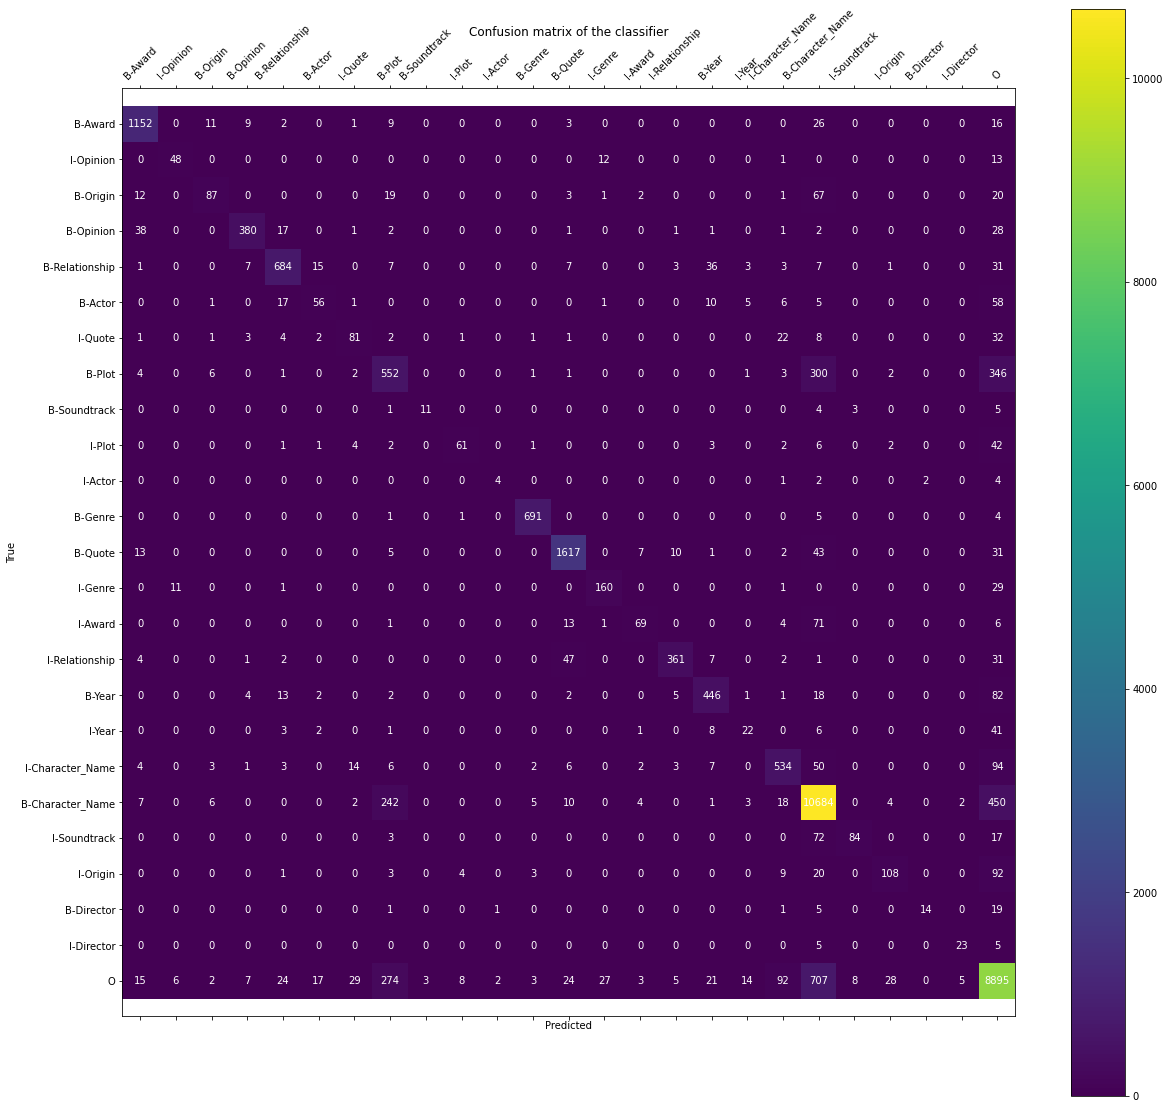

In [ ]:
confusion_matrix_heatmap(y_test,preds)

In [ ]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [ ]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [ ]:
print_transition_weights(ct._tagger.info().transitions.items())

8.505513 I-Plot   -> I-Plot
7.433014 B-Plot   -> I-Plot
6.722163 I-Origin -> I-Origin
6.662524 B-Actor  -> I-Actor
6.381518 I-Relationship -> I-Relationship
6.282731 I-Quote  -> I-Quote
6.126314 B-Director -> I-Director
6.120070 B-Origin -> I-Origin
5.878772 I-Opinion -> I-Opinion
5.726739 B-Relationship -> I-Relationship
5.719770 B-Character_Name -> I-Character_Name
5.684996 B-Genre  -> I-Genre
5.575191 B-Opinion -> I-Opinion
5.389046 I-Actor  -> I-Actor
5.282257 I-Genre  -> I-Genre
5.139929 I-Award  -> I-Award
5.103855 I-Soundtrack -> I-Soundtrack
4.878836 B-Quote  -> I-Quote
4.752448 B-Award  -> I-Award
4.746783 O        -> O
4.715014 I-Character_Name -> I-Character_Name
4.465767 B-Soundtrack -> I-Soundtrack
4.177573 O        -> B-Plot
3.924198 I-Director -> I-Director
3.793142 O        -> B-Actor
3.485750 I-Year   -> I-Year
3.478648 O        -> B-Genre
3.463408 B-Year   -> I-Year
3.273075 O        -> B-Director
3.202856 O        -> B-Character_Name
3.156824 O        -> B-Origin
3.0

In [ ]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [ ]:
print_most_predictive_state_features(ct._tagger.info().state_features.items(),top_k=20)

2.952681 B-Director WORD_i-2_directed
2.168247 B-Quote  QUOTE_INDICATOR_BEFORE
2.143349 I-Year   WORD_i_s
2.143349 I-Year   POS_i_BES
2.119320 B-Actor  WORD_i-2_played
2.080546 B-Year   PREF_19
2.051657 B-Character_Name CHAR_NAME_FIRST
1.995045 B-Character_Name WORD_i-1_named
1.959156 B-Character_Name WORD_i-1_character
1.899121 B-Year   HAS_NUM
1.872871 B-Genre  PREF_ani
1.703330 B-Genre  PREF_thr
1.694611 B-Genre  WORD_i_animated
1.677967 B-Genre  WORD_i_action
1.649945 B-Year   PREF_20
1.649357 B-Soundtrack SONG_INDICATOR_BEFORE
1.590319 B-Award  PREF_osc
1.575808 B-Award  PREF_os
1.562619 B-Actor  WORD_i-1_starring
1.558616 B-Plot   PLOT_INDICATOR_BEFORE


In [ ]:
# gets the lowest scoring k classes 
def get_lowest_scoring_classes (clfReport,metric,num_classes=5):
  all_classes = [i for i in clfReport if i not in ["weighted avg","macro avg","accuracy" ]  ]
  lowest_scoring_classes= sorted(all_classes,key=lambda clfReportClass: clfReport[clfReportClass][metric])[0:num_classes]
  return lowest_scoring_classes

In [ ]:
def false_positives_analysis (data,classes):
  all_false_positives={ cls:[] for cls in classes}
  for sent in data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    sentence = [s[0].split("@")[0] for s in sent]
    for i,pred in enumerate(sent_preds):
      if (pred in classes): # this is one of the classes that we care about
          if(sent_true[i] != pred):# this is a false positive 
            false_positive = "'"+sentence[i]+"'" + " in : " + "'" +" ".join(sentence) + "'" + "\n"+ "true : "+sent_true[i] +"\n"
            all_false_positives[pred].append(false_positive)

    '''print(sentence)
    print(" ".join(sentence))
    print(sent_preds)
    print(sent_true);'''
    #print(all_false_positives)
  return all_false_positives

In [ ]:
clfReport = classification_report(y_test, preds,output_dict=True)
classes = get_lowest_scoring_classes(clfReport,metric="precision")
false_positives = false_positives_analysis(validation_data,classes )
print("\n","\n")
print("lowest precision classes " , classes)
print("\n","\n")
for k in false_positives:
  print(k + " class false positives : ------------------------------------------------------------------ \n")
  for i,fp in enumerate(false_positives[k]):
    print(str(i+1) +". "+ fp)


 

lowest precision classes  ['I-Opinion', 'B-Plot', 'B-Soundtrack', 'B-Opinion', 'B-Origin']

 

I-Opinion class false positives : ------------------------------------------------------------------ 

1. 'bird' in : 'this fun bird watching comedy from 2011 stars jack black owen wilson and steve martin'
true : O

2. 'watching' in : 'this fun bird watching comedy from 2011 stars jack black owen wilson and steve martin'
true : O

3. 'kung' in : 'this is one of the most famous kung fu movies of all time about two warriors in pursuit of a stolen sword'
true : B-Genre

4. 'fu' in : 'this is one of the most famous kung fu movies of all time about two warriors in pursuit of a stolen sword'
true : I-Genre

5. 'movies' in : 'this is one of the most famous kung fu movies of all time about two warriors in pursuit of a stolen sword'
true : B-Plot

6. 'of' in : 'this is one of the most famous kung fu movies of all time about two warriors in pursuit of a stolen sword'
true : I-Plot

7. 'all' in : 't

In [ ]:
def false_negative_analysis (data,classes):
  all_false_negatives={ cls:[] for cls in classes}
  for sent in data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    sentence = [s[0].split("@")[0] for s in sent]
    for i,true in enumerate(sent_true):
      if (true in classes): # this is one of the classes that we care about
          if(sent_preds[i] != true):# this is a false negative 
            false_negative = "'"+sentence[i]+"'" + " in : " + "'" +" ".join(sentence) + "'" + "\n"+ "predicted : "+sent_preds[i] +"\n"
            all_false_negatives[true].append(false_negative)


  return all_false_negatives

In [ ]:
clfReport = classification_report(y_test, preds,output_dict=True)
classes = get_lowest_scoring_classes(clfReport,metric="recall")
false_negatives = false_negative_analysis(validation_data,classes )
print("\n","\n")
print("lowest recall classes ",classes)
print("\n","\n")
for k in false_negatives:
  print(k + " class false negative : ------------------------------------------------------------------ \n")
  for i,fn in enumerate(false_negatives[k]):
    print(str(i+1) +". "+ fn)


 

lowest recall classes  ['I-Opinion', 'B-Soundtrack', 'I-Soundtrack', 'B-Opinion', 'B-Character_Name']

 

I-Opinion class false negative : ------------------------------------------------------------------ 

1. 'memorable' in : 'one of the most memorable scenes from this film involve a boy riding his bike through the sky'
predicted : O

2. 'scenes' in : 'one of the most memorable scenes from this film involve a boy riding his bike through the sky'
predicted : O

3. 'candy' in : 'this 2012 movie is eye candy for the ladies this movie is set in the world of the male stripper'
predicted : I-Character_Name

4. 'packed' in : 'this action packed futuristic thriller about time travel stars bruce willis and joseph gordon levitt as a 20 something willis'
predicted : O

5. 'awaited' in : 'this disney film was a long awaited sequel to the science fiction thriller starring jeff bridges in the world of living computer programs'
predicted : O

6. 'famous' in : 'this horror movie features one of 

In [ ]:
data =  [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
pre_processed = preProcess(data)
print(pre_processed)

[('steve@PRPVBP@True@True', 'B-Actor'), ('mcqueen@CD@True@True', 'I-Actor'), ('provided@VBN@False@False', 'O'), ('a@DT@False@False', 'O'), ('thrilling@VBG@False@False', 'B-Plot'), ('motorcycle@NN@False@False', 'I-Plot'), ('chase@VB@True@True', 'I-Plot'), ('in@IN@False@False', 'I-Plot'), ('this@DT@False@False', 'I-Plot'), ('greatest@JJS@False@False', 'B-Opinion'), ('of@IN@False@False', 'I-Opinion'), ('all@DT@True@False', 'I-Opinion'), ('ww@VB@False@False', 'B-Plot'), ('2@CD@False@False', 'I-Plot'), ('prison@NN@True@False', 'I-Plot'), ('escape@NN@False@False', 'I-Plot'), ('movies@NNS@False@False', 'I-Plot')]


In [ ]:
def test(data):
  print("testing tagger...")
  preds = []
  y_test = []
  for sent in data:
      sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
      sent_true = [s[1] for s in sent]
      preds.extend(sent_preds)
      y_test.extend(sent_true)
      pass
  print("done")
  return preds, y_test

In [ ]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data =[]
for example_idx in range(len(raw_test_data)):
  test_data.append(preProcess(raw_test_data[example_idx]))
  percentage_done = ((example_idx+1)/len(raw_test_data) )*100
  percentage_done = round(percentage_done,2)
  sys.stdout.write('\r'+"pre processing... " + str(percentage_done)+"%")
print()
#test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

preds, y_test = test(test_data)

pre processing... 100.0%
1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger...
done


In [ ]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.91      0.93      0.92      1274
         B-Award       0.70      0.68      0.69        66
B-Character_Name       0.74      0.45      0.56       283
      B-Director       0.86      0.81      0.84       425
         B-Genre       0.81      0.79      0.80       789
       B-Opinion       0.44      0.32      0.37       195
        B-Origin       0.46      0.36      0.40       190
          B-Plot       0.52      0.50      0.51      1577
         B-Quote       0.90      0.40      0.56        47
  B-Relationship       0.79      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.97      0.98      0.97       661
         I-Actor       0.92      0.94      0.93      1553
         I-Award       0.74      0.76      0.75       147
I-Character_Name       0.78      0.51      0.62       227
      I-Director       0.91      0.83      0.87       411
         I-Ge

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---


**From here downwords I record all experiments results**

---









**After spliting the trainging data to train and validation sets**


---



In [ ]:
'''
                   precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1229
         B-Award       0.77      0.62      0.69        74
B-Character_Name       0.65      0.13      0.22       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1219
         B-Quote       0.50      0.12      0.20        24
  B-Relationship       0.82      0.41      0.55       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.89      0.84      0.87      1729
         I-Award       0.83      0.80      0.82       202
I-Character_Name       0.61      0.12      0.20       165
      I-Director       0.86      0.66      0.74       456
         I-Genre       0.79      0.74      0.76       576
       I-Opinion       0.07      0.10      0.08        84
        I-Origin       0.66      0.71      0.68       729
          I-Plot       0.84      0.95      0.89     11438
         I-Quote       0.55      0.19      0.28       176
  I-Relationship       0.59      0.41      0.48       240
    I-Soundtrack       0.00      0.00      0.00        41
          I-Year       0.77      0.82      0.79        33
               O       0.86      0.83      0.85     10219

        accuracy                           0.83     31282
       macro avg       0.65      0.52      0.55     31282
    weighted avg       0.82      0.83      0.82     31282

(0.6453484024582753, 0.5150823812946631, 0.5515964166616931, None)
'''

'\n                   precision    recall  f1-score   support\n\n         B-Actor       0.87      0.87      0.87      1229\n         B-Award       0.77      0.62      0.69        74\nB-Character_Name       0.65      0.13      0.22       212\n      B-Director       0.86      0.67      0.75       472\n         B-Genre       0.86      0.78      0.82       805\n       B-Opinion       0.47      0.23      0.30       160\n        B-Origin       0.57      0.43      0.49       159\n          B-Plot       0.49      0.46      0.47      1219\n         B-Quote       0.50      0.12      0.20        24\n  B-Relationship       0.82      0.41      0.55       125\n    B-Soundtrack       0.00      0.00      0.00        13\n          B-Year       0.97      0.99      0.98       702\n         I-Actor       0.89      0.84      0.87      1729\n         I-Award       0.83      0.80      0.82       202\nI-Character_Name       0.61      0.12      0.20       165\n      I-Director       0.86      0.66      0.74   

After incoperating a POS tagger

---

In [ ]:
'''
precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1229
         B-Award       0.76      0.61      0.68        74
B-Character_Name       0.63      0.15      0.24       212
      B-Director       0.85      0.67      0.75       472
         B-Genre       0.86      0.79      0.82       805
       B-Opinion       0.49      0.24      0.32       160
        B-Origin       0.59      0.44      0.51       159
          B-Plot       0.50      0.46      0.48      1219
         B-Quote       0.38      0.12      0.19        24
  B-Relationship       0.81      0.42      0.55       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.87      0.87      0.87      1729
         I-Award       0.80      0.81      0.80       202
I-Character_Name       0.61      0.14      0.23       165
      I-Director       0.85      0.65      0.74       456
         I-Genre       0.80      0.74      0.77       576
       I-Opinion       0.09      0.10      0.09        84
        I-Origin       0.67      0.70      0.69       729
          I-Plot       0.84      0.94      0.89     11438
         I-Quote       0.65      0.23      0.34       176
  I-Relationship       0.53      0.43      0.48       240
    I-Soundtrack       0.00      0.00      0.00        41
          I-Year       0.77      0.82      0.79        33
               O       0.86      0.83      0.85     10219

        accuracy                           0.83     31282
       macro avg       0.64      0.52      0.56     31282
    weighted avg       0.82      0.83      0.82     31282

(0.6417892197025006, 0.5217415274365258, 0.5567948401990532, None)
'''

'\nprecision    recall  f1-score   support\n\n         B-Actor       0.86      0.89      0.87      1229\n         B-Award       0.76      0.61      0.68        74\nB-Character_Name       0.63      0.15      0.24       212\n      B-Director       0.85      0.67      0.75       472\n         B-Genre       0.86      0.79      0.82       805\n       B-Opinion       0.49      0.24      0.32       160\n        B-Origin       0.59      0.44      0.51       159\n          B-Plot       0.50      0.46      0.48      1219\n         B-Quote       0.38      0.12      0.19        24\n  B-Relationship       0.81      0.42      0.55       125\n    B-Soundtrack       0.00      0.00      0.00        13\n          B-Year       0.97      0.99      0.98       702\n         I-Actor       0.87      0.87      0.87      1729\n         I-Award       0.80      0.81      0.80       202\nI-Character_Name       0.61      0.14      0.23       165\n      I-Director       0.85      0.65      0.74       456\n         I

After adding a window of 1 for both Words and Pos tags

---

In [ ]:
'''
  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1229
         B-Award       0.77      0.64      0.70        74
B-Character_Name       0.80      0.37      0.51       212
      B-Director       0.88      0.75      0.81       472
         B-Genre       0.88      0.81      0.84       805
       B-Opinion       0.59      0.34      0.43       160
        B-Origin       0.61      0.49      0.54       159
          B-Plot       0.50      0.46      0.48      1219
         B-Quote       0.78      0.29      0.42        24
  B-Relationship       0.80      0.49      0.61       125
    B-Soundtrack       0.67      0.15      0.25        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.93      0.93      0.93      1729
         I-Award       0.80      0.76      0.78       202
I-Character_Name       0.83      0.38      0.52       165
      I-Director       0.90      0.74      0.81       456
         I-Genre       0.80      0.77      0.79       576
       I-Opinion       0.15      0.13      0.14        84
        I-Origin       0.75      0.72      0.74       729
          I-Plot       0.87      0.94      0.90     11438
         I-Quote       0.84      0.32      0.46       176
  I-Relationship       0.69      0.43      0.53       240
    I-Soundtrack       1.00      0.10      0.18        41
          I-Year       0.77      0.73      0.75        33
               O       0.85      0.85      0.85     10219

        accuracy                           0.85     31282
       macro avg       0.77      0.58      0.64     31282
    weighted avg       0.85      0.85      0.84     31282

(0.7733274291985297, 0.5808534840822962, 0.6350960838324994, None)
'''

'\n  precision    recall  f1-score   support\n\n         B-Actor       0.92      0.93      0.92      1229\n         B-Award       0.77      0.64      0.70        74\nB-Character_Name       0.80      0.37      0.51       212\n      B-Director       0.88      0.75      0.81       472\n         B-Genre       0.88      0.81      0.84       805\n       B-Opinion       0.59      0.34      0.43       160\n        B-Origin       0.61      0.49      0.54       159\n          B-Plot       0.50      0.46      0.48      1219\n         B-Quote       0.78      0.29      0.42        24\n  B-Relationship       0.80      0.49      0.61       125\n    B-Soundtrack       0.67      0.15      0.25        13\n          B-Year       0.97      0.99      0.98       702\n         I-Actor       0.93      0.93      0.93      1729\n         I-Award       0.80      0.76      0.78       202\nI-Character_Name       0.83      0.38      0.52       165\n      I-Director       0.90      0.74      0.81       456\n        

After adding a window of 2 for both Words and Pos tags

---

In [ ]:
'''
  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1229
         B-Award       0.75      0.66      0.71        74
B-Character_Name       0.77      0.37      0.50       212
      B-Director       0.91      0.78      0.84       472
         B-Genre       0.88      0.83      0.85       805
       B-Opinion       0.59      0.32      0.41       160
        B-Origin       0.59      0.50      0.54       159
          B-Plot       0.50      0.46      0.48      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.83      0.48      0.61       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.98      0.99      0.98       702
         I-Actor       0.92      0.93      0.93      1729
         I-Award       0.82      0.78      0.80       202
I-Character_Name       0.81      0.41      0.55       165
      I-Director       0.92      0.77      0.84       456
         I-Genre       0.80      0.76      0.78       576
       I-Opinion       0.24      0.18      0.21        84
        I-Origin       0.76      0.72      0.74       729
          I-Plot       0.87      0.94      0.90     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.77      0.48      0.59       240
    I-Soundtrack       0.90      0.22      0.35        41
          I-Year       0.78      0.76      0.77        33
               O       0.85      0.86      0.86     10219

        accuracy                           0.85     31282
       macro avg       0.77      0.60      0.65     31282
    weighted avg       0.85      0.85      0.85     31282

(0.7693782918767158, 0.5977371758836124, 0.6531625851029058, None)
'''

'\n  precision    recall  f1-score   support\n\n         B-Actor       0.92      0.93      0.93      1229\n         B-Award       0.75      0.66      0.71        74\nB-Character_Name       0.77      0.37      0.50       212\n      B-Director       0.91      0.78      0.84       472\n         B-Genre       0.88      0.83      0.85       805\n       B-Opinion       0.59      0.32      0.41       160\n        B-Origin       0.59      0.50      0.54       159\n          B-Plot       0.50      0.46      0.48      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.83      0.48      0.61       125\n    B-Soundtrack       0.50      0.15      0.24        13\n          B-Year       0.98      0.99      0.98       702\n         I-Actor       0.92      0.93      0.93      1729\n         I-Award       0.82      0.78      0.80       202\nI-Character_Name       0.81      0.41      0.55       165\n      I-Director       0.92      0.77      0.84       456\n        

After adding a window of 3 for both Words and Pos tags

---



In [ ]:
''' 
  precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.93      1229
         B-Award       0.77      0.66      0.71        74
B-Character_Name       0.76      0.36      0.49       212
      B-Director       0.91      0.79      0.84       472
         B-Genre       0.88      0.82      0.85       805
       B-Opinion       0.52      0.27      0.36       160
        B-Origin       0.55      0.44      0.49       159
          B-Plot       0.49      0.46      0.48      1219
         B-Quote       0.78      0.29      0.42        24
  B-Relationship       0.81      0.48      0.60       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.92      0.94      0.93      1729
         I-Award       0.81      0.77      0.79       202
I-Character_Name       0.82      0.39      0.53       165
      I-Director       0.92      0.78      0.84       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.27      0.10      0.14        84
        I-Origin       0.76      0.70      0.73       729
          I-Plot       0.87      0.93      0.90     11438
         I-Quote       0.85      0.32      0.47       176
  I-Relationship       0.70      0.48      0.57       240
    I-Soundtrack       0.90      0.22      0.35        41
          I-Year       0.76      0.67      0.71        33
               O       0.85      0.86      0.86     10219

        accuracy                           0.85     31282
       macro avg       0.76      0.58      0.64     31282
    weighted avg       0.85      0.85      0.85     31282

(0.7642469299253054, 0.583455092540662, 0.6399359276511286, None)
'''

' \n  precision    recall  f1-score   support\n\n         B-Actor       0.93      0.94      0.93      1229\n         B-Award       0.77      0.66      0.71        74\nB-Character_Name       0.76      0.36      0.49       212\n      B-Director       0.91      0.79      0.84       472\n         B-Genre       0.88      0.82      0.85       805\n       B-Opinion       0.52      0.27      0.36       160\n        B-Origin       0.55      0.44      0.49       159\n          B-Plot       0.49      0.46      0.48      1219\n         B-Quote       0.78      0.29      0.42        24\n  B-Relationship       0.81      0.48      0.60       125\n    B-Soundtrack       0.50      0.15      0.24        13\n          B-Year       0.97      0.99      0.98       702\n         I-Actor       0.92      0.94      0.93      1729\n         I-Award       0.81      0.77      0.79       202\nI-Character_Name       0.82      0.39      0.53       165\n      I-Director       0.92      0.78      0.84       456\n       

After adding a window of 4 for both Words and Pos tags

---



In [ ]:
'''
  precision    recall  f1-score   support

         B-Actor       0.94      0.93      0.93      1229
         B-Award       0.76      0.64      0.69        74
B-Character_Name       0.74      0.33      0.46       212
      B-Director       0.89      0.80      0.84       472
         B-Genre       0.87      0.82      0.85       805
       B-Opinion       0.55      0.27      0.36       160
        B-Origin       0.56      0.45      0.50       159
          B-Plot       0.47      0.44      0.45      1219
         B-Quote       0.75      0.38      0.50        24
  B-Relationship       0.80      0.45      0.57       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.97      0.99      0.98       702
         I-Actor       0.93      0.95      0.94      1729
         I-Award       0.79      0.75      0.77       202
I-Character_Name       0.79      0.35      0.49       165
      I-Director       0.90      0.79      0.84       456
         I-Genre       0.78      0.77      0.77       576
       I-Opinion       0.25      0.08      0.12        84
        I-Origin       0.76      0.71      0.74       729
          I-Plot       0.87      0.93      0.90     11438
         I-Quote       0.85      0.40      0.55       176
  I-Relationship       0.68      0.42      0.52       240
    I-Soundtrack       0.90      0.22      0.35        41
          I-Year       0.72      0.64      0.68        33
               O       0.85      0.86      0.85     10219

        accuracy                           0.85     31282
       macro avg       0.76      0.58      0.64     31282
    weighted avg       0.84      0.85      0.84     31282

(0.7553034402287717, 0.5804319612766574, 0.6360078292932202, None)
'''

'\n  precision    recall  f1-score   support\n\n         B-Actor       0.94      0.93      0.93      1229\n         B-Award       0.76      0.64      0.69        74\nB-Character_Name       0.74      0.33      0.46       212\n      B-Director       0.89      0.80      0.84       472\n         B-Genre       0.87      0.82      0.85       805\n       B-Opinion       0.55      0.27      0.36       160\n        B-Origin       0.56      0.45      0.50       159\n          B-Plot       0.47      0.44      0.45      1219\n         B-Quote       0.75      0.38      0.50        24\n  B-Relationship       0.80      0.45      0.57       125\n    B-Soundtrack       0.50      0.15      0.24        13\n          B-Year       0.97      0.99      0.98       702\n         I-Actor       0.93      0.95      0.94      1729\n         I-Award       0.79      0.75      0.77       202\nI-Character_Name       0.79      0.35      0.49       165\n      I-Director       0.90      0.79      0.84       456\n        

window of 2, up to 2 suffex , up to 2 prefex

---

In [ ]:
'''
 precision    recall  f1-score   support

         B-Actor       0.91      0.93      0.92      1229
         B-Award       0.73      0.64      0.68        74
B-Character_Name       0.71      0.35      0.47       212
      B-Director       0.90      0.79      0.84       472
         B-Genre       0.88      0.84      0.86       805
       B-Opinion       0.58      0.33      0.42       160
        B-Origin       0.60      0.48      0.53       159
          B-Plot       0.50      0.46      0.48      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.82      0.47      0.60       125
    B-Soundtrack       0.67      0.15      0.25        13
          B-Year       0.98      0.99      0.98       702
         I-Actor       0.92      0.93      0.93      1729
         I-Award       0.77      0.77      0.77       202
I-Character_Name       0.76      0.36      0.49       165
      I-Director       0.91      0.78      0.84       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.32      0.21      0.26        84
        I-Origin       0.74      0.71      0.73       729
          I-Plot       0.88      0.94      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.75      0.45      0.56       240
    I-Soundtrack       1.00      0.15      0.26        41
          I-Year       0.77      0.70      0.73        33
               O       0.86      0.87      0.86     10219

        accuracy                           0.85     31282
       macro avg       0.77      0.59      0.64     31282
    weighted avg       0.85      0.85      0.85     31282

(0.7732695754831747, 0.589873501015499, 0.6439780635209236, None)
'''

'\n precision    recall  f1-score   support\n\n         B-Actor       0.91      0.93      0.92      1229\n         B-Award       0.73      0.64      0.68        74\nB-Character_Name       0.71      0.35      0.47       212\n      B-Director       0.90      0.79      0.84       472\n         B-Genre       0.88      0.84      0.86       805\n       B-Opinion       0.58      0.33      0.42       160\n        B-Origin       0.60      0.48      0.53       159\n          B-Plot       0.50      0.46      0.48      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.82      0.47      0.60       125\n    B-Soundtrack       0.67      0.15      0.25        13\n          B-Year       0.98      0.99      0.98       702\n         I-Actor       0.92      0.93      0.93      1729\n         I-Award       0.77      0.77      0.77       202\nI-Character_Name       0.76      0.36      0.49       165\n      I-Director       0.91      0.78      0.84       456\n         

window of 2, up to 3 suffex , up to 3 prefex

---

In [ ]:
'''
  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1229
         B-Award       0.74      0.66      0.70        74
B-Character_Name       0.75      0.39      0.51       212
      B-Director       0.92      0.80      0.85       472
         B-Genre       0.87      0.84      0.86       805
       B-Opinion       0.56      0.34      0.43       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.46      0.47      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.93      1729
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.80      0.42      0.55       165
      I-Director       0.92      0.78      0.85       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.29      0.26      0.28        84
        I-Origin       0.75      0.73      0.74       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.77      0.45      0.57       240
    I-Soundtrack       0.90      0.22      0.35        41
          I-Year       0.76      0.67      0.71        33
               O       0.85      0.87      0.86     10219

        accuracy                           0.85     31282
       macro avg       0.77      0.60      0.66     31282
    weighted avg       0.85      0.85      0.85     31282

(0.7665005795843493, 0.6022588331111179, 0.6554552039400767, None)
'''

'\n  precision    recall  f1-score   support\n\n         B-Actor       0.92      0.93      0.93      1229\n         B-Award       0.74      0.66      0.70        74\nB-Character_Name       0.75      0.39      0.51       212\n      B-Director       0.92      0.80      0.85       472\n         B-Genre       0.87      0.84      0.86       805\n       B-Opinion       0.56      0.34      0.43       160\n        B-Origin       0.60      0.51      0.55       159\n          B-Plot       0.49      0.46      0.47      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.81      0.49      0.61       125\n    B-Soundtrack       0.50      0.15      0.24        13\n          B-Year       0.98      0.98      0.98       702\n         I-Actor       0.93      0.94      0.93      1729\n         I-Award       0.79      0.79      0.79       202\nI-Character_Name       0.80      0.42      0.55       165\n      I-Director       0.92      0.78      0.85       456\n        

window of 2, up to 4 suffex , up to 4 prefex

---

In [ ]:
'''
precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1229
         B-Award       0.73      0.65      0.69        74
B-Character_Name       0.74      0.38      0.50       212
      B-Director       0.92      0.79      0.85       472
         B-Genre       0.88      0.85      0.87       805
       B-Opinion       0.58      0.36      0.44       160
        B-Origin       0.60      0.52      0.55       159
          B-Plot       0.49      0.46      0.48      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.78      0.48      0.59       125
    B-Soundtrack       0.33      0.08      0.12        13
          B-Year       0.98      0.99      0.98       702
         I-Actor       0.94      0.93      0.93      1729
         I-Award       0.80      0.77      0.78       202
I-Character_Name       0.80      0.40      0.53       165
      I-Director       0.93      0.78      0.85       456
         I-Genre       0.81      0.78      0.79       576
       I-Opinion       0.37      0.20      0.26        84
        I-Origin       0.75      0.74      0.75       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.77      0.47      0.58       240
    I-Soundtrack       0.86      0.15      0.25        41
          I-Year       0.79      0.70      0.74        33
               O       0.86      0.87      0.86     10219

        accuracy                           0.86     31282
       macro avg       0.76      0.59      0.65     31282
    weighted avg       0.85      0.86      0.85     31282

(0.7622559703450098, 0.594676278548423, 0.6474373916980121, None)
'''

'\nprecision    recall  f1-score   support\n\n         B-Actor       0.92      0.93      0.93      1229\n         B-Award       0.73      0.65      0.69        74\nB-Character_Name       0.74      0.38      0.50       212\n      B-Director       0.92      0.79      0.85       472\n         B-Genre       0.88      0.85      0.87       805\n       B-Opinion       0.58      0.36      0.44       160\n        B-Origin       0.60      0.52      0.55       159\n          B-Plot       0.49      0.46      0.48      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.78      0.48      0.59       125\n    B-Soundtrack       0.33      0.08      0.12        13\n          B-Year       0.98      0.99      0.98       702\n         I-Actor       0.94      0.93      0.93      1729\n         I-Award       0.80      0.77      0.78       202\nI-Character_Name       0.80      0.40      0.53       165\n      I-Director       0.93      0.78      0.85       456\n         I

after using the best configurations so far (window = 2,prefix=3 , suffix =3) + adding the character name dataset

---

In [ ]:
'''
  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1229
         B-Award       0.73      0.66      0.70        74
B-Character_Name       0.74      0.41      0.53       212
      B-Director       0.92      0.80      0.86       472
         B-Genre       0.88      0.85      0.87       805
       B-Opinion       0.59      0.35      0.44       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.45      0.47      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.75      0.23      0.35        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.94      1729
         I-Award       0.80      0.79      0.79       202
I-Character_Name       0.78      0.42      0.54       165
      I-Director       0.93      0.79      0.85       456
         I-Genre       0.82      0.77      0.80       576
       I-Opinion       0.39      0.26      0.31        84
        I-Origin       0.76      0.73      0.75       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.74      0.45      0.56       240
    I-Soundtrack       1.00      0.22      0.36        41
          I-Year       0.77      0.70      0.73        33
               O       0.85      0.87      0.86     10219

        accuracy                           0.86     31282
       macro avg       0.79      0.61      0.67     31282
    weighted avg       0.85      0.86      0.85     31282

(0.7854454697453503, 0.6090095583269354, 0.66503757268049, None)
'''

'\n  precision    recall  f1-score   support\n\n         B-Actor       0.92      0.94      0.93      1229\n         B-Award       0.73      0.66      0.70        74\nB-Character_Name       0.74      0.41      0.53       212\n      B-Director       0.92      0.80      0.86       472\n         B-Genre       0.88      0.85      0.87       805\n       B-Opinion       0.59      0.35      0.44       160\n        B-Origin       0.60      0.51      0.55       159\n          B-Plot       0.49      0.45      0.47      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.81      0.49      0.61       125\n    B-Soundtrack       0.75      0.23      0.35        13\n          B-Year       0.98      0.98      0.98       702\n         I-Actor       0.93      0.94      0.94      1729\n         I-Award       0.80      0.79      0.79       202\nI-Character_Name       0.78      0.42      0.54       165\n      I-Director       0.93      0.79      0.85       456\n        

After using Song indicators

---

In [ ]:
'''
 precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1229
         B-Award       0.73      0.66      0.70        74
B-Character_Name       0.74      0.41      0.53       212
      B-Director       0.92      0.80      0.86       472
         B-Genre       0.88      0.85      0.87       805
       B-Opinion       0.58      0.35      0.44       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.45      0.47      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.57      0.31      0.40        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.94      1729
         I-Award       0.80      0.79      0.79       202
I-Character_Name       0.77      0.43      0.55       165
      I-Director       0.93      0.79      0.85       456
         I-Genre       0.82      0.77      0.80       576
       I-Opinion       0.39      0.26      0.31        84
        I-Origin       0.76      0.73      0.75       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.74      0.45      0.56       240
    I-Soundtrack       0.88      0.34      0.49        41
          I-Year       0.77      0.70      0.73        33
               O       0.86      0.87      0.86     10219

        accuracy                           0.86     31282
       macro avg       0.77      0.62      0.67     31282
    weighted avg       0.85      0.86      0.85     31282

(0.7723232128630911, 0.6174559557365088, 0.6722591652748287, None)

'''

'\n precision    recall  f1-score   support\n\n         B-Actor       0.92      0.94      0.93      1229\n         B-Award       0.73      0.66      0.70        74\nB-Character_Name       0.74      0.41      0.53       212\n      B-Director       0.92      0.80      0.86       472\n         B-Genre       0.88      0.85      0.87       805\n       B-Opinion       0.58      0.35      0.44       160\n        B-Origin       0.60      0.51      0.55       159\n          B-Plot       0.49      0.45      0.47      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.81      0.49      0.61       125\n    B-Soundtrack       0.57      0.31      0.40        13\n          B-Year       0.98      0.98      0.98       702\n         I-Actor       0.93      0.94      0.94      1729\n         I-Award       0.80      0.79      0.79       202\nI-Character_Name       0.77      0.43      0.55       165\n      I-Director       0.93      0.79      0.85       456\n         

after using Plot indicators

---

In [ ]:
'''
               precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1229
         B-Award       0.73      0.66      0.70        74
B-Character_Name       0.74      0.41      0.53       212
      B-Director       0.92      0.80      0.86       472
         B-Genre       0.88      0.85      0.87       805
       B-Opinion       0.59      0.35      0.44       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.45      0.47      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.57      0.31      0.40        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.93      1729
         I-Award       0.80      0.79      0.79       202
I-Character_Name       0.78      0.42      0.54       165
      I-Director       0.93      0.79      0.85       456
         I-Genre       0.82      0.77      0.80       576
       I-Opinion       0.45      0.26      0.33        84
        I-Origin       0.76      0.73      0.75       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.74      0.45      0.56       240
    I-Soundtrack       0.88      0.34      0.49        41
          I-Year       0.77      0.70      0.73        33
               O       0.86      0.87      0.86     10219

        accuracy                           0.86     31282
       macro avg       0.78      0.62      0.67     31282
    weighted avg       0.85      0.86      0.85     31282

(0.7753341811533135, 0.617057052266235, 0.6727474199888103, None)
'''

'\n               precision    recall  f1-score   support\n\n         B-Actor       0.92      0.94      0.93      1229\n         B-Award       0.73      0.66      0.70        74\nB-Character_Name       0.74      0.41      0.53       212\n      B-Director       0.92      0.80      0.86       472\n         B-Genre       0.88      0.85      0.87       805\n       B-Opinion       0.59      0.35      0.44       160\n        B-Origin       0.60      0.51      0.55       159\n          B-Plot       0.49      0.45      0.47      1219\n         B-Quote       0.70      0.29      0.41        24\n  B-Relationship       0.81      0.49      0.61       125\n    B-Soundtrack       0.57      0.31      0.40        13\n          B-Year       0.98      0.98      0.98       702\n         I-Actor       0.93      0.94      0.93      1729\n         I-Award       0.80      0.79      0.79       202\nI-Character_Name       0.78      0.42      0.54       165\n      I-Director       0.93      0.79      0.85       

after using Opinion indicators

---

In [ ]:
 '''precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1229
         B-Award       0.73      0.66      0.70        74
B-Character_Name       0.74      0.41      0.53       212
      B-Director       0.92      0.81      0.86       472
         B-Genre       0.89      0.85      0.87       805
       B-Opinion       0.58      0.35      0.44       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.46      0.47      1219
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.57      0.31      0.40        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.93      1729
         I-Award       0.80      0.80      0.80       202
I-Character_Name       0.78      0.42      0.54       165
      I-Director       0.93      0.79      0.86       456
         I-Genre       0.82      0.77      0.80       576
       I-Opinion       0.45      0.26      0.33        84
        I-Origin       0.76      0.73      0.75       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.86      0.38      0.53       176
  I-Relationship       0.74      0.45      0.56       240
    I-Soundtrack       0.88      0.34      0.49        41
          I-Year       0.77      0.70      0.73        33
               O       0.86      0.87      0.86     10219

        accuracy                           0.86     31282
       macro avg       0.78      0.62      0.67     31282
    weighted avg       0.85      0.86      0.85     31282

(0.7754841745120291, 0.6175399419811892, 0.6731217546850846, None)'''

'precision    recall  f1-score   support\n\n        B-Actor       0.92      0.94      0.93      1229\n        B-Award       0.73      0.66      0.70        74\nB-Character_Name       0.74      0.41      0.53       212\n     B-Director       0.92      0.81      0.86       472\n        B-Genre       0.89      0.85      0.87       805\n      B-Opinion       0.58      0.35      0.44       160\n       B-Origin       0.60      0.51      0.55       159\n         B-Plot       0.49      0.46      0.47      1219\n        B-Quote       0.70      0.29      0.41        24\n B-Relationship       0.81      0.49      0.61       125\n   B-Soundtrack       0.57      0.31      0.40        13\n         B-Year       0.98      0.98      0.98       702\n        I-Actor       0.93      0.94      0.93      1729\n        I-Award       0.80      0.80      0.80       202\nI-Character_Name       0.78      0.42      0.54       165\n     I-Director       0.93      0.79      0.86       456\n        I-Genre       0.82

after using Quote Indicators

---

In [ ]:
'''
               precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1229
         B-Award       0.74      0.65      0.69        74
B-Character_Name       0.74      0.41      0.53       212
      B-Director       0.92      0.81      0.86       472
         B-Genre       0.88      0.85      0.87       805
       B-Opinion       0.59      0.35      0.44       160
        B-Origin       0.60      0.51      0.55       159
          B-Plot       0.49      0.45      0.47      1219
         B-Quote       0.79      0.46      0.58        24
  B-Relationship       0.81      0.49      0.61       125
    B-Soundtrack       0.57      0.31      0.40        13
          B-Year       0.98      0.98      0.98       702
         I-Actor       0.93      0.94      0.93      1729
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.78      0.42      0.55       165
      I-Director       0.93      0.79      0.86       456
         I-Genre       0.82      0.77      0.80       576
       I-Opinion       0.45      0.26      0.33        84
        I-Origin       0.76      0.73      0.75       729
          I-Plot       0.88      0.93      0.91     11438
         I-Quote       0.88      0.48      0.62       176
  I-Relationship       0.74      0.45      0.56       240
    I-Soundtrack       0.88      0.34      0.49        41
          I-Year       0.77      0.70      0.73        33
               O       0.86      0.87      0.86     10219

        accuracy                           0.86     31282
       macro avg       0.78      0.63      0.68     31282
    weighted avg       0.85      0.86      0.85     31282

(0.7805516540556432, 0.627114460854866, 0.6831471077149144, None)
'''

'\n               precision    recall  f1-score   support\n\n         B-Actor       0.92      0.94      0.93      1229\n         B-Award       0.74      0.65      0.69        74\nB-Character_Name       0.74      0.41      0.53       212\n      B-Director       0.92      0.81      0.86       472\n         B-Genre       0.88      0.85      0.87       805\n       B-Opinion       0.59      0.35      0.44       160\n        B-Origin       0.60      0.51      0.55       159\n          B-Plot       0.49      0.45      0.47      1219\n         B-Quote       0.79      0.46      0.58        24\n  B-Relationship       0.81      0.49      0.61       125\n    B-Soundtrack       0.57      0.31      0.40        13\n          B-Year       0.98      0.98      0.98       702\n         I-Actor       0.93      0.94      0.93      1729\n         I-Award       0.79      0.79      0.79       202\nI-Character_Name       0.78      0.42      0.55       165\n      I-Director       0.93      0.79      0.86       

In [ ]:
''' I also tried different configurations for min document frequency , C1, and C2. However, nothing gave better results than 0.68'''